In [26]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from sklearn.linear_model import LogisticRegression
import ssm

## Load Results

In [27]:
def predict(hmm, X, y):
    states = hmm.most_likely_states(
        y, input=X
        )
    pred_y = []
    for idx, x in enumerate(X):
        state = states[idx]
        input_with_constant = np.hstack(
            (x, 1)
            )
        logit_ps = input_with_constant @ hmm.observations.coef[state]
        ps = 1/(1 + np.exp(-1*logit_ps))
        if ps > 0.5:
            pred_y.append(1)
        else:
            pred_y.append(0)
    return np.array(pred_y)

In [28]:
def plot_psychometric_clf(clf):
    if clf.coef_.size == 2:
        data_prevl = []
        data_prevr = []
        for delta in range(-35,36):
            data_prevl.append([0,delta])
            data_prevr.append([1,delta])
        data_prevl = np.array(data_prevl)
        data_prevr = np.array(data_prevr)
        psychometric_curve_prevl = clf.predict_proba(data_prevl)
        psychometric_curve_prevr = clf.predict_proba(data_prevr)
        plt.plot(
            range(-35, 36),
            psychometric_curve_prevl[:,1], color="blue",
            label="Previous Choice Left"
            )
        plt.plot(
            range(-35, 36),
            psychometric_curve_prevr[:,1], color="red",
            label="Previous Choice Right"
            )
        plt.title("Probability of Choosing Right")
        plt.legend()
        plt.xlabel("More Left Beeps >>> More Right Beeps")
        plt.ylim((0,1))
        plt.axhline(0.5, color="gray")
        plt.axvline(0, color="gray")
        plt.show()
    elif clf.coef_.size == 3:
        array_names = [
            "Auditory; Prev L",
            "Auditory; Prev R",
            "Tactile; Prev L",
            "Tactile; Prev R"
            ]
        plot_style = ["-b", "-r", "--b", "--r"]
        data_arrays = [[] for _ in range(len(array_names))]
        for delta in range(-35,36):
            data_arrays[0].append([0,delta,1])
            data_arrays[1].append([1,delta,1])
            data_arrays[2].append([0,delta,0])
            data_arrays[3].append([1,delta,0])
        data_arrays = [
            np.array(d) for d in data_arrays
            ]
        psycurves = [
            clf.predict_proba(d) for d in data_arrays
            ]
        plt.figure()
        for i in range(len(array_names)):
            plt.plot(
                range(-35, 36),
                psycurves[i][:,1], plot_style[i],
                label=array_names[i]
                )
        plt.title("Probability of Choosing Right")
        plt.legend()
        plt.xlabel("More Left Beeps >>> More Right Beeps")
        plt.ylim((0,1))
        plt.axhline(0.5, color="gray")
        plt.axvline(0, color="gray")
        plt.show()

def plot_psychometric_coefs(coefs):
    clf = LogisticRegression()
    clf.coef_ = np.array([coefs[:-1]])
    clf.intercept_ = np.array([coefs[-1]])
    plot_psychometric_clf(clf)

In [29]:
def find_best_p_weight(results):
    """
    Assuming results is a dictionary over prior weights. Each entry
    of the dictionary is a list of 20 runs of the GLMHMM
    """
    
    best_p_weight = None
    best_score = -np.inf
    for p_weight in results.keys():
        sample_glmhmms = results[p_weight]
        sample_scores = [s['test_ll'] for s in sample_glmhmms]
        score = max(sample_scores)
        if score > best_score:
            best_p_weight = p_weight
            best_score = score
    return best_p_weight

In [44]:
filename = "tacaud"
results_K = pickle.load(open(
    filename + "_glmhmm_results.p", "rb"
    ))
data = pickle.load(open(
    "pickles/" + filename + "_glmhmm_data.p", "rb"
    ))
X_test = data["X_test"]
y_test = data["y_test"]
X_train = data["X_train"]
y_train = data["y_train"]

## Test performance as a function of latent dimension

In [45]:
# Collect log likelihoods
test_lls = []
pred_scores = []
Ks = []
Ks_p_weights = []
for K in results_K.keys():
    p_weight = find_best_p_weight(results_K[K])
    results = results_K[K][p_weight]
    Ks_p_weights.append(p_weight)
    for result in results:
        hmm = result['hmm']
        test_lls.append(result['test_ll'])
        pred_choices = predict(hmm, X_test, y_test)
        pred_score = np.sum(pred_choices == y_test.flatten())/y_test.size
        pred_scores.append(pred_score)
        Ks.append(K)
df = pd.DataFrame({
    'Ks': Ks, 'test_lls': test_lls, 'pred_scores': pred_scores
    })

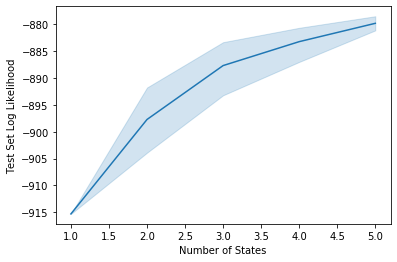

In [46]:
# Plot Log-Likes as a function of dimensions
sns.lineplot(
    x="Ks", y="test_lls", data=df
    )
plt.ylabel("Test Set Log Likelihood")
plt.xlabel("Number of States")
plt.show()

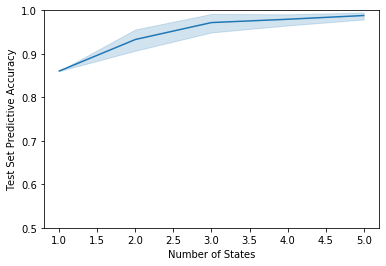

In [47]:
# Plot Log-Likes as a function of dimensions
sns.lineplot(
    x="Ks", y="pred_scores", data=df
    )
plt.ylabel("Test Set Predictive Accuracy")
plt.xlabel("Number of States")
plt.ylim(0.5, 1)
plt.show()

In [48]:
Ks_p_weights

[10.0, 0.001, 0.01, 0.001, 0.1]

## Comparing inferred psychometric curves

In [54]:
K = 3
p_weight = 0.01

In [55]:
results = results_K[K][p_weight]
results_test_lls = [r['test_ll'] for r in results]
hmm = results[np.argmax(results_test_lls)]['hmm']

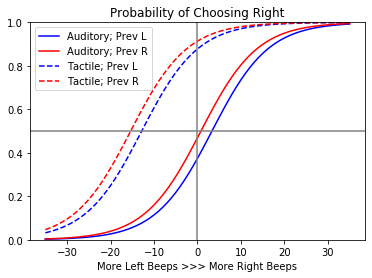

In [56]:
plot_psychometric_coefs(hmm.observations.coef[0])

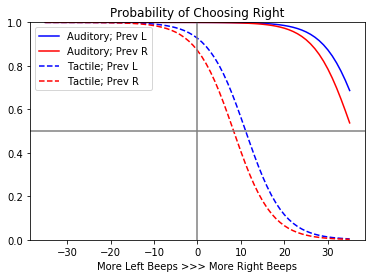

In [57]:
plot_psychometric_coefs(hmm.observations.coef[1])

## Testing accuracy: predicted states and predicted choices

In [22]:
predicted_test = hmm.most_likely_states(
    y_test, input=X_test
    )
predicted_train = hmm.most_likely_states(
    y_train, input=X_train
    )

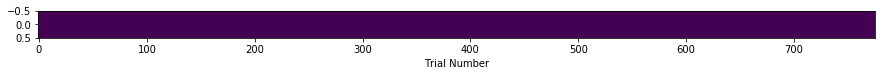

In [23]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    predicted_test.reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()

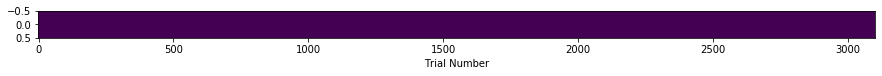

In [24]:
plt.figure(figsize=(15,0.5))
plt.imshow(
    predicted_train.reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.show()

## Generating Data

In [25]:
animal = 'mSM63'
folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
dates = os.listdir(folder)
dates.sort()
dates = dates[1:]
dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y')) 

In [1]:
task_type = "aud"

In [38]:
# Create dataset
aud_dates = dates[41:68]
audtac_dates = dates[31:41]
tacaud_dates = dates[41:68]
if task_type == "aud":
    task_dates = aud_dates
elif task_type == "audtac":
    task_dates = aud_dates
elif task_type == "tacaud":
    task_dates = aud_dates
all_X = []
all_y = []
all_indices = []
curr_index = 0

for date_idx, date in enumerate(task_dates):
    session = LearningSession(
        animal, date, access_engram=True, load_neural=False
        )
    predictor = LearningPsychometricPredictor(
        session, audtac=True)
    trial_choices = predictor.trial_choices
    nonnan_choices = np.logical_not(np.isnan(trial_choices))
    nonnan_data = np.ones((nonnan_choices.shape)).astype(bool)
    for trial in range(predictor.data.shape[0]):
        if np.sum(np.isnan(predictor.data[trial,:])) > 0:
            nonnan_data[trial] = False
    nonnan_indices = np.logical_and(nonnan_choices, nonnan_data)
    y = trial_choices[nonnan_indices].astype(int) - 1
    y = y.reshape((-1,1))
    X = predictor.data[nonnan_indices,:]
    indices = np.vstack(
        (np.arange(y.size) + curr_index, np.ones(y.size)*date_idx)
        ).T
    all_X.append(X)
    all_y.append(y)
    all_indices.append(indices)
    curr_index += y.size
all_X = np.vstack(all_X)
all_y = np.vstack(all_y)
all_indices = np.vstack(all_indices)
X_train, X_test, y_train, y_test, train_indices, test_indices = \
    train_test_split(
        all_X, all_y, all_indices, test_size = 0.20, stratify=all_y
        )

data = {
    "X_train": X_train, "X_test": X_test,
    "y_train":y_train, "y_test": y_test,
    "train_indices": train_indices, "test_indices": test_indices
    }
pickle.dump(data, open(
    task_type + "_glmhmmdata.p", "wb"
    ))

KeyboardInterrupt: 